<a href="https://colab.research.google.com/github/sudeepmenon17/PytorchforNN/blob/main/AirfoilS809_SAmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install google-auth

In [2]:
from google.colab import auth
from google.colab import drive

In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# !ls /content/drive/MyDrive/


In [5]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
# Create a Model class
class Model(nn.Module):
  def __init__(self,in_features=6, h1 = 61, h2 = 60, out_features=1):
    super().__init__()
    self.fc1 = nn.Linear(in_features,h1)
    self.dropout1 = nn.Dropout(0.25)
    self.fc2 = nn.Linear(h1,h2)
    self.dropout2 = nn.Dropout(0.25)
    # self.fc3 = nn.Linear(h2,h3)
    # self.dropout3 = nn.Dropout(0.25)
    self.out = nn.Linear(h2,out_features)

  def forward(self,x):
    x = F.sigmoid(self.fc1(x))
    x = self.dropout1(x)
    x = F.sigmoid(self.fc2(x))
    x = self.dropout2(x)
    # x = F.sigmoid(self.fc3(x))
    # x = self.dropout3(x)
    x = self.out(x)

    return x

In [7]:
torch.manual_seed(42)

model = Model()

In [8]:
# Read the data set -  Airfoil S809
df1 = pd.read_csv("/content/drive/MyDrive/data_set1.csv")
df2 = pd.read_csv("/content/drive/MyDrive/data_set2.csv")
df3 = pd.read_csv("/content/drive/MyDrive/data_set3.csv")
df4 = pd.read_csv("/content/drive/MyDrive/data_set4.csv")


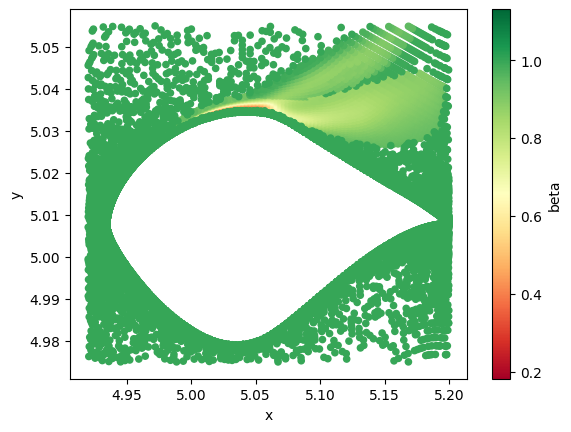

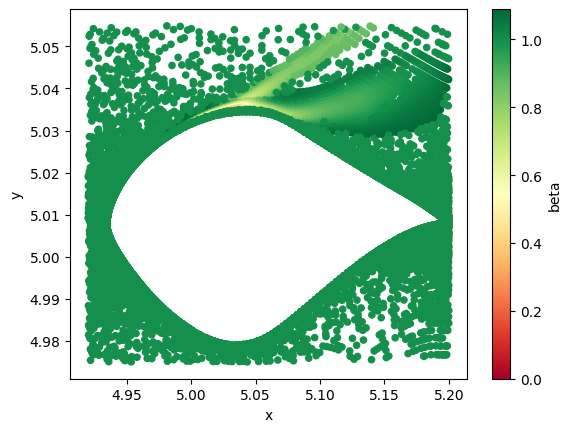

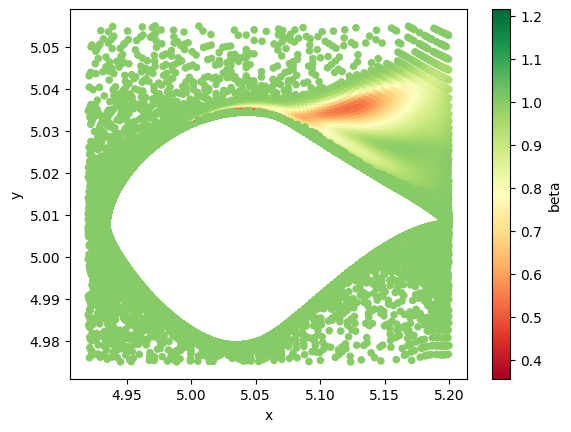

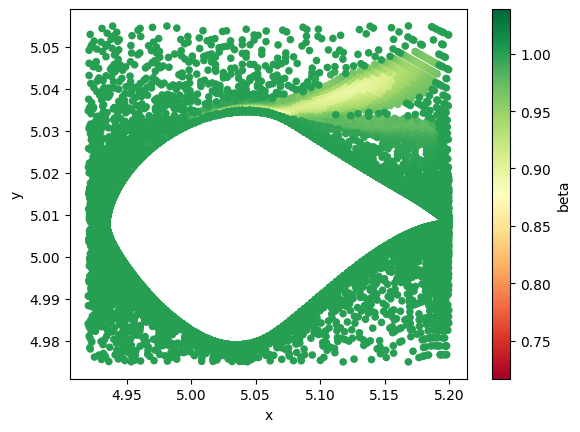

In [9]:
# Combine data
frames = [df1, df2, df3, df4]
ff = []

for item in frames:
  xc = np.array(item['x'])
  yc = np.array(item['y'])
  b = np.array(item['beta'])
  ff1 = np.array(item['feature1'])
  ff2 = np.array(item['feature2'])
  ff3 = np.array(item['feature3'])
  ff4 = np.array(item['feature4'])
  ff5 = np.array(item['feature5'])
  ff6 = np.array(item['feature6'])

  # Normalize x and y coordinates
  min_range = -5.0
  max_range = 5.0
  xc = (xc - np.min(xc)) * (max_range - min_range) / (np.max(xc) - np.min(xc))
  yc = (yc - np.min(yc)) * (max_range - min_range) / (np.max(yc) - np.min(yc))


  # #####################################################################
  # # Cleaning the beta field in the wake region
  # for k in range(len(xc)):
  #   if xc[k] >= 5.2 and xc[k] <= 5.3:
  #     if yc[k] >= 5.00 and yc[k] <= 4.96:
  #       b2.append(b[k])

  # for j in range(len(xc)):
  #   if xc[j] > 5.15 or yc[j]>5.04:
  #     b[j] = np.mean(b2)

  x1,y1,b1,f1,f2,f3,f4,f5,f6 = [[] for i in range(9)]
  # Filter data for the specified range of coordinates
  for i in range(len(xc)):
    if xc[i]>=4.92 and xc[i]<=5.20:
      if yc[i]>=4.975 and yc[i]<=5.055:
        # if (b[i]<0.995) | (b[i]>1.005):
          x1.append(xc[i])
          y1.append(yc[i])
          b1.append(b[i])
          f1.append(ff1[i])
          f2.append(ff2[i])
          f3.append(ff3[i])
          f4.append(ff4[i])
          f5.append(ff5[i])
          f6.append(ff6[i])
        # else:
        #   nnn = np.random.uniform(0,1)
        #   if nnn < 0.10:
        #     x1.append(xc[i])
        #     y1.append(yc[i])
        #     b1.append(b[i])
        #     f1.append(ff1[i])
        #     f2.append(ff2[i])
        #     f3.append(ff3[i])
        #     f4.append(ff4[i])
        #     f5.append(ff5[i])
        #     f6.append(ff6[i])

  modified_data = {
  'x': np.array(x1),
  'y': np.array(y1),
  'beta': np.array(b1),
  'feature1': np.array(f1),
  'feature2': np.array(f2),
  'feature3': np.array(f3),
  'feature4': np.array(f4),
  'feature5': np.array(f5),
  'feature6': np.array(f6)
  }




  cf = pd.DataFrame(modified_data)
  # Data for beta>1.005 or beta<0.995
  s1 = cf[(cf['beta'] < 0.995) | (cf['beta'] > 1.005)]
  s2 = cf[(cf['beta'] >= 0.995) & (cf['beta'] <= 1.005)]


  s3 = s2.sample(frac=0.25, random_state=1)
  df_filtered = pd.concat([s1, s3], ignore_index=True)

  # df_filtered.shape[0], s1.shape[0], s2.shape[0], s3.shape[0]

  ax = df_filtered.plot.scatter(x='x',
                      y='y',
                      c='beta',
                      colormap='RdYlGn')

  ff.append(df_filtered)

  # # #####################################################################
  # # Plotting cleaned data
  # ################################
  # nx = []
  # ny = []
  # nb = []


  # # Filter data for the specified range of coordinates
  # for i in range(len(xc)):
  #   if xc[i]>=4.9 and xc[i]<=5.3:
  #     if yc[i]>=4.925 and yc[i]<=5.075:
  #       nx.append(xc[i])
  #       ny.append(yc[i])
  #       nb.append(b[i])

  # # Create a scatter plot
  # plt.scatter(x1, y1, c=b1,  cmap= 'RdYlGn',alpha=1, marker='.',s=250)
  # plt.colorbar(label='Beta Field')
  # plt.xlabel('X Coordinate')
  # plt.ylabel('Y Coordinate')
  # plt.title('Domain for training')
  # plt.show()
###############################################################################

df = pd.concat(ff)


# # Data for beta>1.02 or beta<0.98
# df_filtered = df[(df['beta'] < 0.995) | (df['beta'] > 1.005)]

# df_filtered = df[df['beta'] != 1.0]

# df_filtered = df



In [10]:
# # Data for beta>1.005 or beta<0.995
# s1 = df[(df['beta'] < 0.995) | (df['beta'] > 1.005)]
# s2 = df[(df['beta'] >= 0.995) & (df['beta'] <= 1.005)]


# s3 = s2.sample(frac=0.1, random_state=1)
# df_filtered = pd.concat([s1, s3], ignore_index=True)

# df_filtered.shape[0], s1.shape[0], s2.shape[0], s3.shape[0]

<Axes: xlabel='feature3', ylabel='Density'>

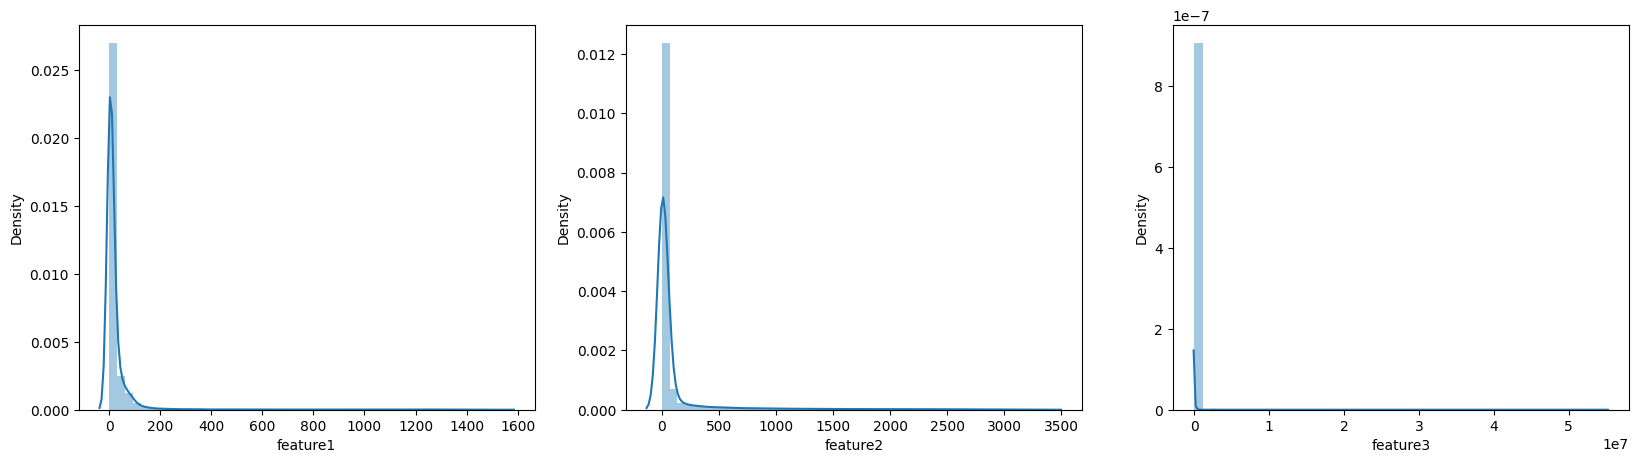

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')




# # Preprocess Features
# df1 = df_filtered.drop(['x','y','beta'],axis=1)
# df2 = df_filtered.drop(['x','y','feature1','feature2','feature3','feature4','feature5','feature6'],axis=1)

df1 = df.drop(['x','y','beta'],axis=1)
df2 = df.drop(['x','y','feature1','feature2','feature3','feature4','feature5','feature6'],axis=1)


plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
sns.distplot(df1['feature1'])
plt.subplot(1,3,2)
sns.distplot(df1['feature2'])
plt.subplot(1,3,3)
sns.distplot(df1['feature3'])



<Axes: xlabel='feature6', ylabel='Density'>

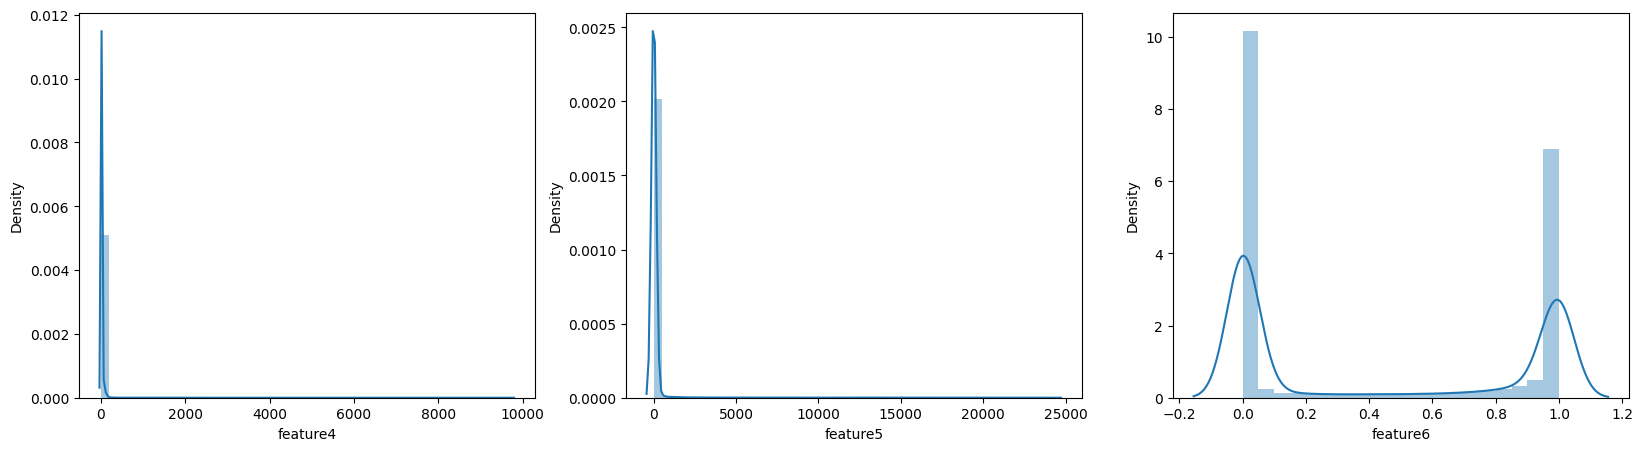

In [12]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
sns.distplot(df1['feature4'])
plt.subplot(1,3,2)
sns.distplot(df1['feature5'])
plt.subplot(1,3,3)
sns.distplot(df1['feature6'])

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import RobustScaler





# # Fill missing values with the mean
# df1 = df1.fillna(df1.mean())
# m = df1.max()
# df1 = df1.div(m)

df1.min(),df1.max()

(feature1    5.310000e-06
 feature2    2.396171e-03
 feature3    1.210074e-02
 feature4    1.430000e-13
 feature5   -1.525873e+00
 feature6    0.000000e+00
 dtype: float64,
 feature1    1.547650e+03
 feature2    3.364014e+03
 feature3    5.517923e+07
 feature4    9.756683e+03
 feature5    2.429828e+04
 feature6    1.000000e+00
 dtype: float64)

In [14]:

# Standardization
# standard_scaler = StandardScaler()
min_max_scaler = MinMaxScaler(feature_range=(0, 10000))
# transformer = Normalizer()
scaler = RobustScaler(with_centering=False)

# Features
# X = min_max_scaler.fit_transform(df1)
X = df1.values

# # Target
# # y = df_filtered['beta'].values
# # y = standard_scaler.fit_transform(df2)
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
# y = min_max_scaler.fit_transform(df2)
# # y = scaler.fit_transform(df2)
y = df2.values

In [15]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001,weight_decay=0.0000001)
# optimizer = torch.optim.SGD(model.parameters(),lr = 0.001,weight_decay=0.0)

In [16]:
#5-Fold Cross Validation
from sklearn import metrics

from sklearn.model_selection import KFold
kFold=KFold(n_splits=5,shuffle=True, random_state=100)

# Initialize a list to store the evaluation scores
scores = []
training_cost = []
testing_cost =[]
iterations = 4000
train_fold = [[] for i in range(5)]
test_fold = [[] for i in range(5)]
c = 0
for train_index,test_index in kFold.split(X):
  print("Train Index: ", train_index, "\n")
  print("Test Index: ", test_index)
  print("Size of training data:", len(train_index),"\n")
  print("Size of testing data:", len(test_index),"\n")

  X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]


  X_train = torch.FloatTensor(X_train)
  X_test = torch.FloatTensor(X_test)

  y_train = torch.FloatTensor(y_train)
  y_test = torch.FloatTensor(y_test)


  losses = []
  for i in range(iterations):
    # go forward and predict
    y_pred = model.forward(X_train)

    # Measure the loss
    loss = criterion(y_pred,y_train)

    # Keep track of the losses
    losses.append(loss.detach().numpy())

    # print every 10 epoch
    if i % 10 == 0:
      print(f'iter: {i} and loss: {loss}')

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  train_fold[c].append(y_pred.detach().numpy())
  train_fold[c].append(y_train.detach().numpy())
  training_cost.append(losses)

  # Evaluate Model
  with torch.no_grad():
    y_eval = model.forward(X_test)
    test_loss = criterion(y_eval,y_test)
  test_fold[c].append(y_eval.detach().numpy())
  test_fold[c].append(y_test.detach().numpy())

  testing_cost.append(test_loss)
  scores.append(metrics.mean_squared_error(y_eval,y_test))
  print('MSEloss: {}'.format(testing_cost))
  print('MSE error: {}'.format(scores))

  c = c+1

Train Index:  [    0     1     2 ... 62148 62149 62150] 

Test Index:  [    3     5     8 ... 62117 62119 62121]
Size of training data: 49720 

Size of testing data: 12431 

iter: 0 and loss: 0.707619309425354
iter: 10 and loss: 0.11593020707368851
iter: 20 and loss: 0.06650709360837936
iter: 30 and loss: 0.06747099757194519
iter: 40 and loss: 0.047401100397109985
iter: 50 and loss: 0.047933511435985565
iter: 60 and loss: 0.0450439490377903
iter: 70 and loss: 0.043492842465639114
iter: 80 and loss: 0.04186546057462692
iter: 90 and loss: 0.0411379300057888
iter: 100 and loss: 0.03996073827147484
iter: 110 and loss: 0.038532670587301254
iter: 120 and loss: 0.037908487021923065
iter: 130 and loss: 0.0363004207611084
iter: 140 and loss: 0.03539185971021652
iter: 150 and loss: 0.03446793183684349
iter: 160 and loss: 0.03338097780942917
iter: 170 and loss: 0.03245954215526581
iter: 180 and loss: 0.03136796876788139
iter: 190 and loss: 0.030768319964408875
iter: 200 and loss: 0.03014813549816

Text(0.5, 1.0, 'Fold5')

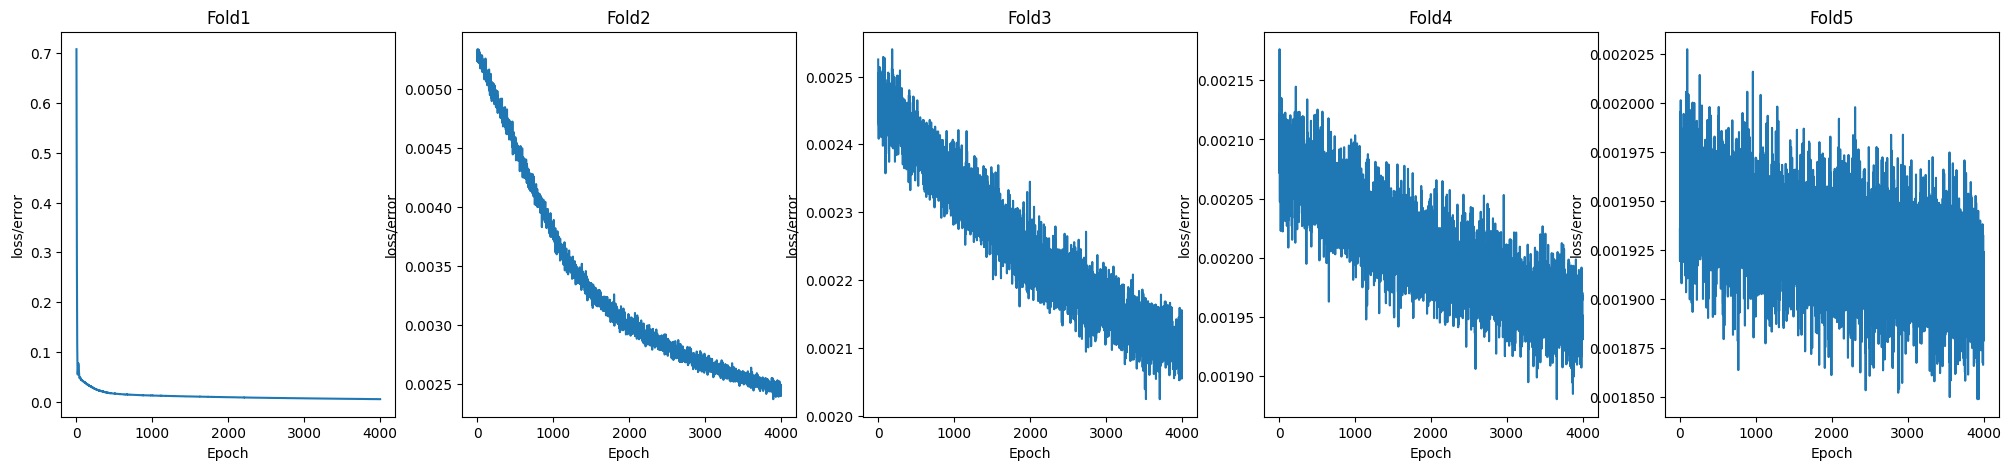

In [17]:
plt.figure(figsize=(25,5))
plt.subplot(1,5,1)
plt.plot(range(iterations), training_cost[0])
plt.ylabel("loss/error")
plt.xlabel('Epoch')
plt.title('Fold1')
plt.subplot(1,5,2)
plt.plot(range(iterations), training_cost[1])
plt.ylabel("loss/error")
plt.xlabel('Epoch')
plt.title('Fold2')
plt.subplot(1,5,3)
plt.plot(range(iterations), training_cost[2])
plt.ylabel("loss/error")
plt.xlabel('Epoch')
plt.title('Fold3')
plt.subplot(1,5,4)
plt.plot(range(iterations), training_cost[3])
plt.ylabel("loss/error")
plt.xlabel('Epoch')
plt.title('Fold4')
plt.subplot(1,5,5)
plt.plot(range(iterations), training_cost[4])
plt.ylabel("loss/error")
plt.xlabel('Epoch')
plt.title('Fold5')

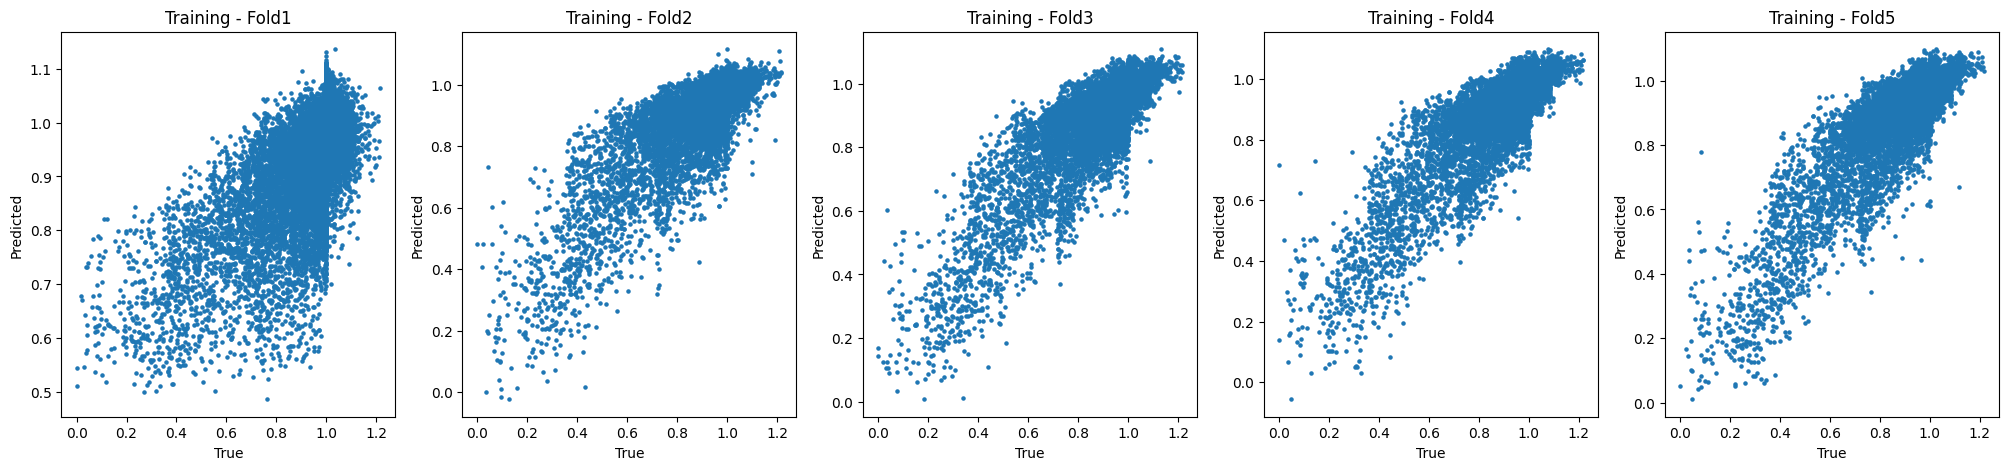

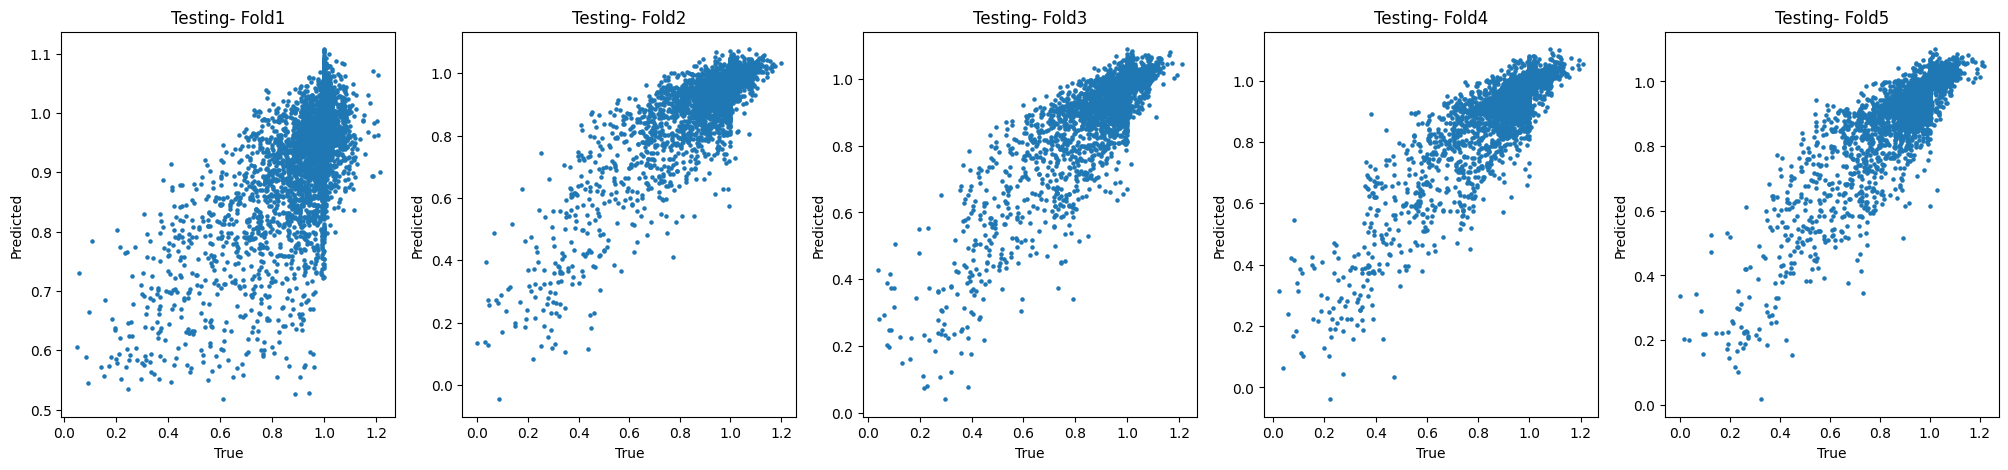

In [18]:
plt.figure(figsize=(25,5))
plt.subplot(1,5,1)
plt.scatter(train_fold[0][1],train_fold[0][0], s=5)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Training - Fold1')
plt.subplot(1,5,2)
plt.scatter(train_fold[1][1],train_fold[1][0], s=5)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Training - Fold2')
plt.subplot(1,5,3)
plt.scatter(train_fold[2][1],train_fold[2][0], s=5)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Training - Fold3')
plt.subplot(1,5,4)
plt.scatter(train_fold[3][1],train_fold[3][0], s=5)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Training - Fold4')
plt.subplot(1,5,5)
plt.scatter(train_fold[4][1],train_fold[4][0], s=5)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Training - Fold5')
# plt.ylim(-4,2)

plt.show()

plt.figure(figsize=(25,5))
plt.subplot(1,5,1)
plt.scatter(test_fold[0][1],test_fold[0][0],s =5 )
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Testing- Fold1')
plt.subplot(1,5,2)
plt.scatter(test_fold[1][1],test_fold[1][0],s =5 )
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Testing- Fold2')
plt.subplot(1,5,3)
plt.scatter(test_fold[2][1],test_fold[2][0],s =5 )
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Testing- Fold3')
plt.subplot(1,5,4)
plt.scatter(test_fold[3][1],test_fold[3][0],s =5 )
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Testing- Fold4')
plt.subplot(1,5,5)
plt.scatter(test_fold[4][1],test_fold[4][0],s =5 )
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Testing- Fold5')


plt.show()

In [19]:
print(model)



Model(
  (fc1): Linear(in_features=6, out_features=61, bias=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=61, out_features=60, bias=True)
  (dropout2): Dropout(p=0.25, inplace=False)
  (out): Linear(in_features=60, out_features=1, bias=True)
)


In [20]:
list(model.parameters())

[Parameter containing:
 tensor([[ 4.0945e-01,  6.4535e-02,  6.0276e-02,  3.2551e-02, -6.9315e-02,
           6.4367e-04],
         [-7.6409e-01,  1.5936e-01, -4.5971e-01,  1.2111e-01,  1.2999e+00,
          -2.2167e-01],
         [ 2.3681e-01,  1.6416e-01,  4.3324e-02,  7.5542e-02,  5.2952e-02,
           7.9835e-04],
         [-1.3517e-01,  8.2367e-02, -1.5802e+00, -8.7404e-03,  6.1132e-02,
           6.0854e+00],
         [-4.0001e-01,  4.6970e-02,  6.1126e-01,  5.3636e-03,  1.7783e-01,
           2.1423e+00],
         [-1.3122e-01, -2.6002e-01,  4.8387e+00, -2.9209e-03,  4.2729e-02,
           7.3842e-01],
         [ 3.8012e-01,  1.9619e-01,  9.5639e-02, -2.1492e-01, -7.9714e-02,
           3.4857e-03],
         [ 3.3908e-01,  2.8134e-01,  7.3215e-02, -1.7357e-01, -7.5913e-02,
           3.0343e-03],
         [ 5.5430e-02, -3.6925e-01,  1.7416e+00, -2.7202e-03, -4.2931e-02,
          -1.4433e+00],
         [ 2.4140e-01,  1.6671e-01,  4.4141e-02,  7.5817e-02,  5.3981e-02,
           

In [21]:
xx = model.fc1.weight

In [22]:
np.shape(xx)

torch.Size([61, 6])

In [23]:
# Save our NN Model
torch.save(model.state_dict(), '/content/drive/MyDrive/airfoil_model.pt')
# Load the Saved Model
new_model = Model()
new_model.load_state_dict(torch.load('/content/drive/MyDrive/airfoil_model.pt'))

<All keys matched successfully>

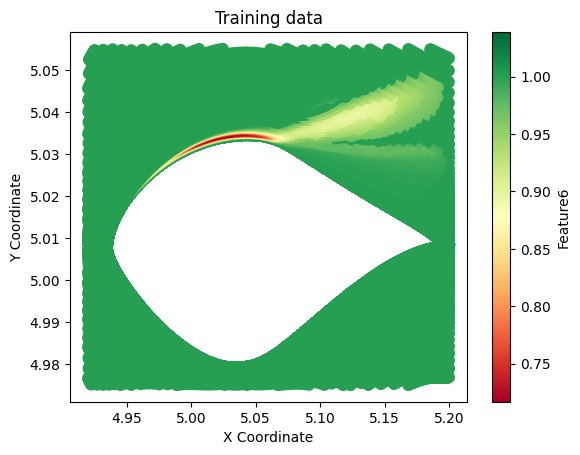

In [30]:
dff = pd.read_csv("/content/drive/MyDrive/data_set4.csv")

# dff.loc[dff['beta']<0.995, "beta"] = 1.5
# dff.loc[dff['beta']>1.005, "beta"] = 1.5


frames = [dff]
ff = []

for item in frames:
  xc = np.array(item['x'])
  yc = np.array(item['y'])
  b = np.array(item['beta'])
  ff1 = np.array(item['feature1'])
  ff2 = np.array(item['feature2'])
  ff3 = np.array(item['feature3'])
  ff4 = np.array(item['feature4'])
  ff5 = np.array(item['feature5'])
  ff6 = np.array(item['feature6'])

  # Normalize x and y coordinates
  min_range = -5.0
  max_range = 5.0
  xc = (xc - np.min(xc)) * (max_range - min_range) / (np.max(xc) - np.min(xc))
  yc = (yc - np.min(yc)) * (max_range - min_range) / (np.max(yc) - np.min(yc))


  x1,y1,b1,f1,f2,f3,f4,f5,f6 = [[] for i in range(9)]
  # Filter data for the specified range of coordinates
  for i in range(len(xc)):
    if xc[i]>=4.92 and xc[i]<=5.20:
      if yc[i]>=4.975 and yc[i]<=5.055:
        # if (b[i]<0.995) | (b[i]>1.005):
          x1.append(xc[i])
          y1.append(yc[i])
          b1.append(b[i])
          f1.append(ff1[i])
          f2.append(ff2[i])
          f3.append(ff3[i])
          f4.append(ff4[i])
          f5.append(ff5[i])
          f6.append(ff6[i])

  modified_data = {
  'x': np.array(x1),
  'y': np.array(y1),
  'beta': np.array(b1),
  'feature1': np.array(f1),
  'feature2': np.array(f2),
  'feature3': np.array(f3),
  'feature4': np.array(f4),
  'feature5': np.array(f5),
  'feature6': np.array(f6)
  }


  ff.append(pd.DataFrame(modified_data))

  # Create a scatter plot
  plt.scatter(x1, y1, c=b1,  cmap= 'RdYlGn',alpha=1, marker='.',s=250)
  plt.colorbar(label='Feature6')
  plt.xlabel('X Coordinate')
  plt.ylabel('Y Coordinate')
  plt.title('Training data')
  plt.show()
###############################################################################

dff1 = pd.concat(ff)


In [31]:
dff2 = dff1.drop(['x','y','beta'],axis=1)
X2 = dff2.values
X2 = torch.FloatTensor(X2)
y2 = new_model.forward(X2)
y2 = y2.detach().numpy()

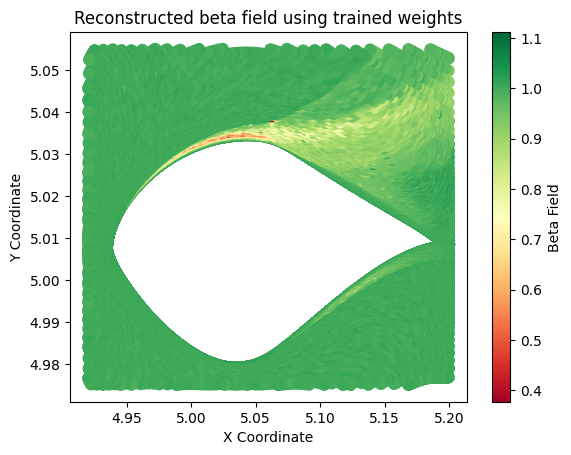

In [32]:
# Create a scatter plot
plt.scatter(x1, y1, c=y2,  cmap= 'RdYlGn',alpha=1, marker='.',s=250)
plt.colorbar(label='Beta Field')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Reconstructed beta field using trained weights')
plt.show()